# 🧭 02_Data_Cleaning — Очистка и предобработка данных

В этом ноутбуке проводится очистка и предобработка данных о квартирах, направленные на улучшение качества информации и подготовку датасета для дальнейшего статистического анализа и проверки гипотез.

---

## 📋 Основные этапы работы

1. **Импорт библиотек и загрузка данных**
2. **Удаление лишних колонок** — убираем `Unnamed: 0` и `code`
3. **Создание новых признаков (feature engineering)**
   - `close_to_center` — пешая доступность до центра *(Yes/No)*
   - `room_type` — тип квартиры по общей площади *(1-, 2-, 3-, 4+ комнат)*
4. **Переименование колонок** — для удобочитаемого формата
5. **Преобразование бинарных признаков**
   - `walkable_to_metro`, `is_brick`, `is_first_or_last_floor` → категории *(Yes/No)*
6. **Очистка данных и удаление выбросов**
   - Фильтрация логически некорректных значений для `kitchen_area`, `total_area`, `living_area`
   - Удаление выбросов по площадям (`total_area`, `living_area`, `kitchen_area`) с помощью метода IQR (k=3)
   - Удаление глобальных выбросов по цене за m^2 (`price_per_m_2`) методом IQR
   - Удаление локальных выбросов по цене за m^2 внутри каждой группы `room_type` (учёт различий между количеством комнат)
7. **Проверка данных после очистки**
   - Просмотр размера очищенного датасета
   - Случайные строки и описательная статистика
8. **Визуальная проверка распределений**
   - `plot_hist_boxplot` для количественных признаков
   - `check_normality` для проверки нормальности
   - `plot_categorial_pie` для категориальных признаков
9. **Сохранение очищенного датасета**

---

## 🎯 Цель

Сформировать чистый и корректный набор данных:
- удалить выбросы и некорректные значения;
- привести признаки к удобному формату;
- создать новые информативные признаки;
- подготовить данные для статистического анализа и проверки гипотез.

---

## 1. Импорт библиотек

In [65]:
import pandas as pd
import numpy as np

from utils.visualization import plot_hist_boxplot, plot_categorial_pie
from utils.cleaning import drop_outliers, drop_outliers_grouped, check_normality

In [66]:
# Загружаем данные
flats = pd.read_csv("../data/raw/flats_moscow.csv")

## 2. Удаление лишних колонок

Убираем колонки, которые не нужны для анализа (`Unnamed: 0` и `code`).

In [67]:
flats.drop("Unnamed: 0", axis=1, inplace=True)
flats.drop("code", axis=1, inplace=True)

## 3. Создание новых признаков (feature engineering)

Добавляем полезные признаки:
- `close_to_center` — пешая доступность до центра (Yes/No)
- `room_type` — тип квартиры по общей площади (1-комнатная, 2-комнатная, 3-комнатная, 4+ комнат)

In [68]:
def is_close_to_center(dist: int) -> str:
    if dist <= 4:
        return "Yes"
    else:
        return "No"

flats["close_to_center"] = flats["dist"].apply(is_close_to_center)

def classify_by_ares(area: int) -> str:
    if area <= 55:
        return "1-комнатная"
    elif 55 < area <= 65:
        return "2-комнатная"
    elif 65 < area <= 78:
        return "3-комнатная"
    else:
        return "4+ комнат"

flats["room_type"] = flats["totsp"].apply(classify_by_ares)

flats["price_per_m_2"] = flats["price"] / flats["totsp"].replace(0, np.nan)

## 4. Переименование колонок

Переименовываем колонки в удобочитаемый формат для дальнейшей работы.

In [69]:
flats.rename(
    columns={
        "totsp": "total_area",
        "livesp": "living_area",
        "kitsp": "kitchen_area",
        "dist": "distance_to_center",
        "metrdist": "distance_to_metro",
        "walk": "walkable_to_metro",
        "brick": "is_brick",
        "floor": "is_middle_floor",
    },
    inplace=True
)

## 5. Преобразование бинарных признаков

Переводим бинарные числовые колонки в категориальные (Yes/No):
- `walkable_to_metro`
- `is_brick`
- `is_first_or_last_floor`

In [70]:
flats[["walkable_to_metro", "is_brick", "is_middle_floor"]] = (
    flats[["walkable_to_metro", "is_brick", "is_middle_floor"]]
    .replace({1: "Yes", 0: "No"})
)

## 6. Очистка данных и удаление выбросов

Удаляем выбросы и некорректные значения для повышения качества данных:

- Сначала фильтруем явные ошибки в данных по площадям:
  - `kitchen_area` — оставляем значения между 3 и 30 м²
  - `total_area` — оставляем значения между 20 и 200 м²
  - `living_area` — проверяем, чтобы жилая площадь не превышала общую

- Далее удаляем экстремальные значения по площадям с помощью метода IQR (k=3):
  - `total_area`
  - `living_area`
  - `kitchen_area`

- Затем удаляем выбросы по цене за квадратный метр:
  - Сначала глобальные выбросы по всей выборке (`drop_outliers`)
  - После этого локальные выбросы внутри каждой группы по количеству комнат (`drop_outliers_grouped`)


In [71]:
flats = flats[
    flats["kitchen_area"].between(3, 30) &                # кухня слишком маленькая/большая
    flats["total_area"].between(20, 200) &               # общая площадь в разумных пределах
    (flats["living_area"] <= flats["total_area"])        # жилая площадь не больше общей
]

# Удаляем выбросы по площади с более щадящим порогом k=3 (широкий диапазон)
drop_outliers(flats, column="total_area", k=3, inplace=True)
drop_outliers(flats, column="living_area", k=3, inplace=True)
drop_outliers(flats, column="kitchen_area", k=3, inplace=True)

# Удаляем глобальные выбросы по цене за квадратный метр
drop_outliers(flats, column="price_per_m_2", inplace=True)

# Удаляем локальные выбросы по цене за квадратный метр внутри каждой группы признака room_type
drop_outliers_grouped(flats, column="price_per_m_2", group_col="room_type", inplace=True)

## 7. Проверка данных после очистки

Оценка размера очищенного датасета, просмотр случайных строк и описательная статистика.

In [72]:
print(f"Размер после очистки: {flats.shape[0]} строк, {flats.shape[1]} колонок")

Размер после очистки: 1890 строк, 12 колонок


In [73]:
flats.sample(5)

,price,total_area,living_area,kitchen_area,distance_to_center,distance_to_metro,walkable_to_metro,is_brick,is_middle_floor,close_to_center,room_type,price_per_m_2
806,125,76,45,10.0,13.5,10,No,No,Yes,No,3-комнатная,1.644737
10,132,96,56,12.0,10.5,7,No,No,Yes,No,4+ комнат,1.375000
1950,95,59,43,6.0,15.5,5,No,No,Yes,No,2-комнатная,1.610169
984,83,52,34,6.0,14.5,10,No,No,No,No,1-комнатная,1.596154
1155,110,75,43,10.0,13.5,15,No,No,Yes,No,3-комнатная,1.466667


In [74]:
flats.describe().T

,count,mean,std,min,25%,50%,75%,max
price,1890.0,117.888360,30.228838,68.000000,95.000000,113.000000,135.000000,300.000000
total_area,1890.0,71.444444,12.436704,44.000000,61.000000,72.000000,78.000000,127.000000
living_area,1890.0,45.458201,6.357582,28.000000,42.000000,45.000000,48.000000,70.000000
kitchen_area,1890.0,8.617460,2.364700,5.000000,6.000000,8.000000,10.000000,19.000000
distance_to_center,1890.0,11.261058,3.266986,3.000000,9.000000,12.000000,13.500000,17.000000
distance_to_metro,1890.0,8.257672,3.782291,1.000000,5.000000,7.000000,10.000000,20.000000
price_per_m_2,1856.0,1.634384,0.251672,0.948052,1.460238,1.583333,1.776681,2.394366


## 8. Визуальная проверка распределений

Строим графики для проверки распределений:
- `plot_hist_boxplot` для количественных признаков
- `check_normality` для оценки нормальности
- `plot_categorial_pie` для категориальных признаков

Эти визуализации помогают убедиться, что данные корректные после очистки и выбрать методы для анализа гипотез.


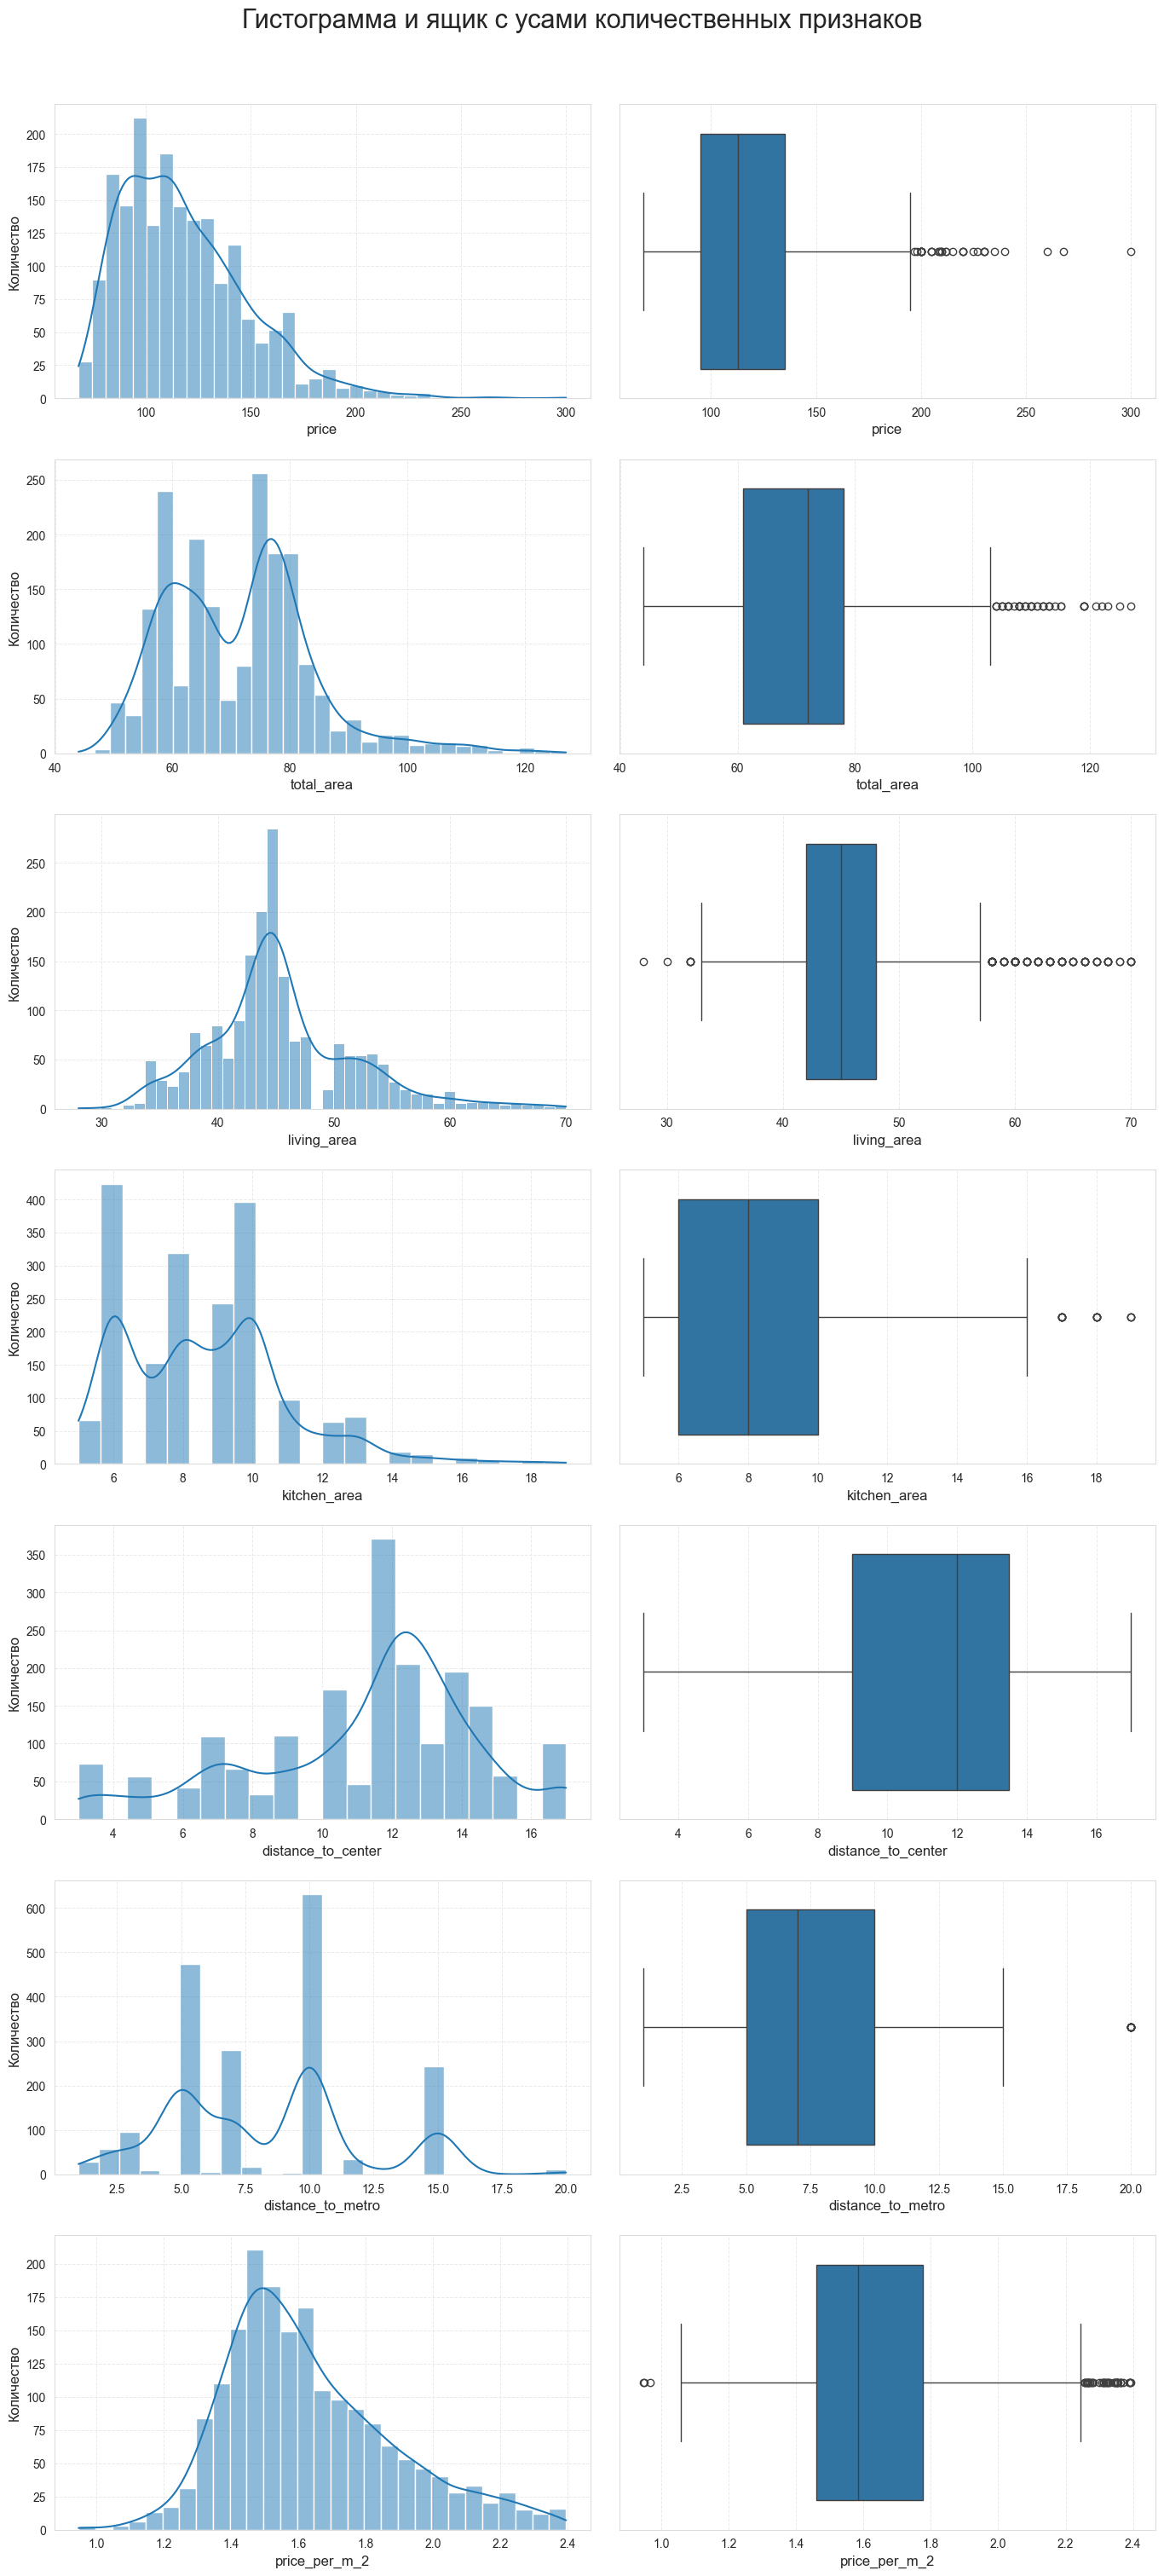

In [75]:
plot_hist_boxplot(flats, flats.select_dtypes(exclude="object").columns, kde=True, save_path="../images/data_cleaning/hist_boxplot.png")

In [76]:
check_normality(flats)

,column,p_value,distribution
0,price,0.0,Асимметричное
1,total_area,0.0,Асимметричное
2,living_area,0.0,Асимметричное
3,kitchen_area,0.0,Асимметричное
4,distance_to_center,0.0,Асимметричное
5,distance_to_metro,0.0,Асимметричное
6,price_per_m_2,0.0,Асимметричное


## 📊 Итоги по количественным данным после очистки

После предобработки и удаления выбросов в данных остались только значимые наблюдения, отражающие реальные характеристики, включая элитные квартиры с высокими ценами и площадью.

Несмотря на очистку, распределения количественных признаков сохранили **асимметричный характер** — с выраженным правым хвостом, что указывает на наличие отдельных объектов с экстремально высокими значениями.

Таким образом, можно сделать вывод, что:
- данные **не подчиняются нормальному распределению** (что подтверждается визуально и статистически);
- использование **параметрических тестов** (например, t-теста, ANOVA) будет некорректным;
- при проверке гипотез и анализе связей стоит применять **непараметрические методы**, такие как:
  - тест **Манна–Уитни (Mann–Whitney U)** — для сравнения двух выборок;
  - тест **Краскала–Уоллиса (Kruskal–Wallis H)** — для сравнения нескольких групп;
  - **коэффициент корреляции Спирмена (Spearman)** — для оценки связи между количественными признаками.

В результате количественные данные можно считать очищенными и готовыми к дальнейшему статистическому анализу.

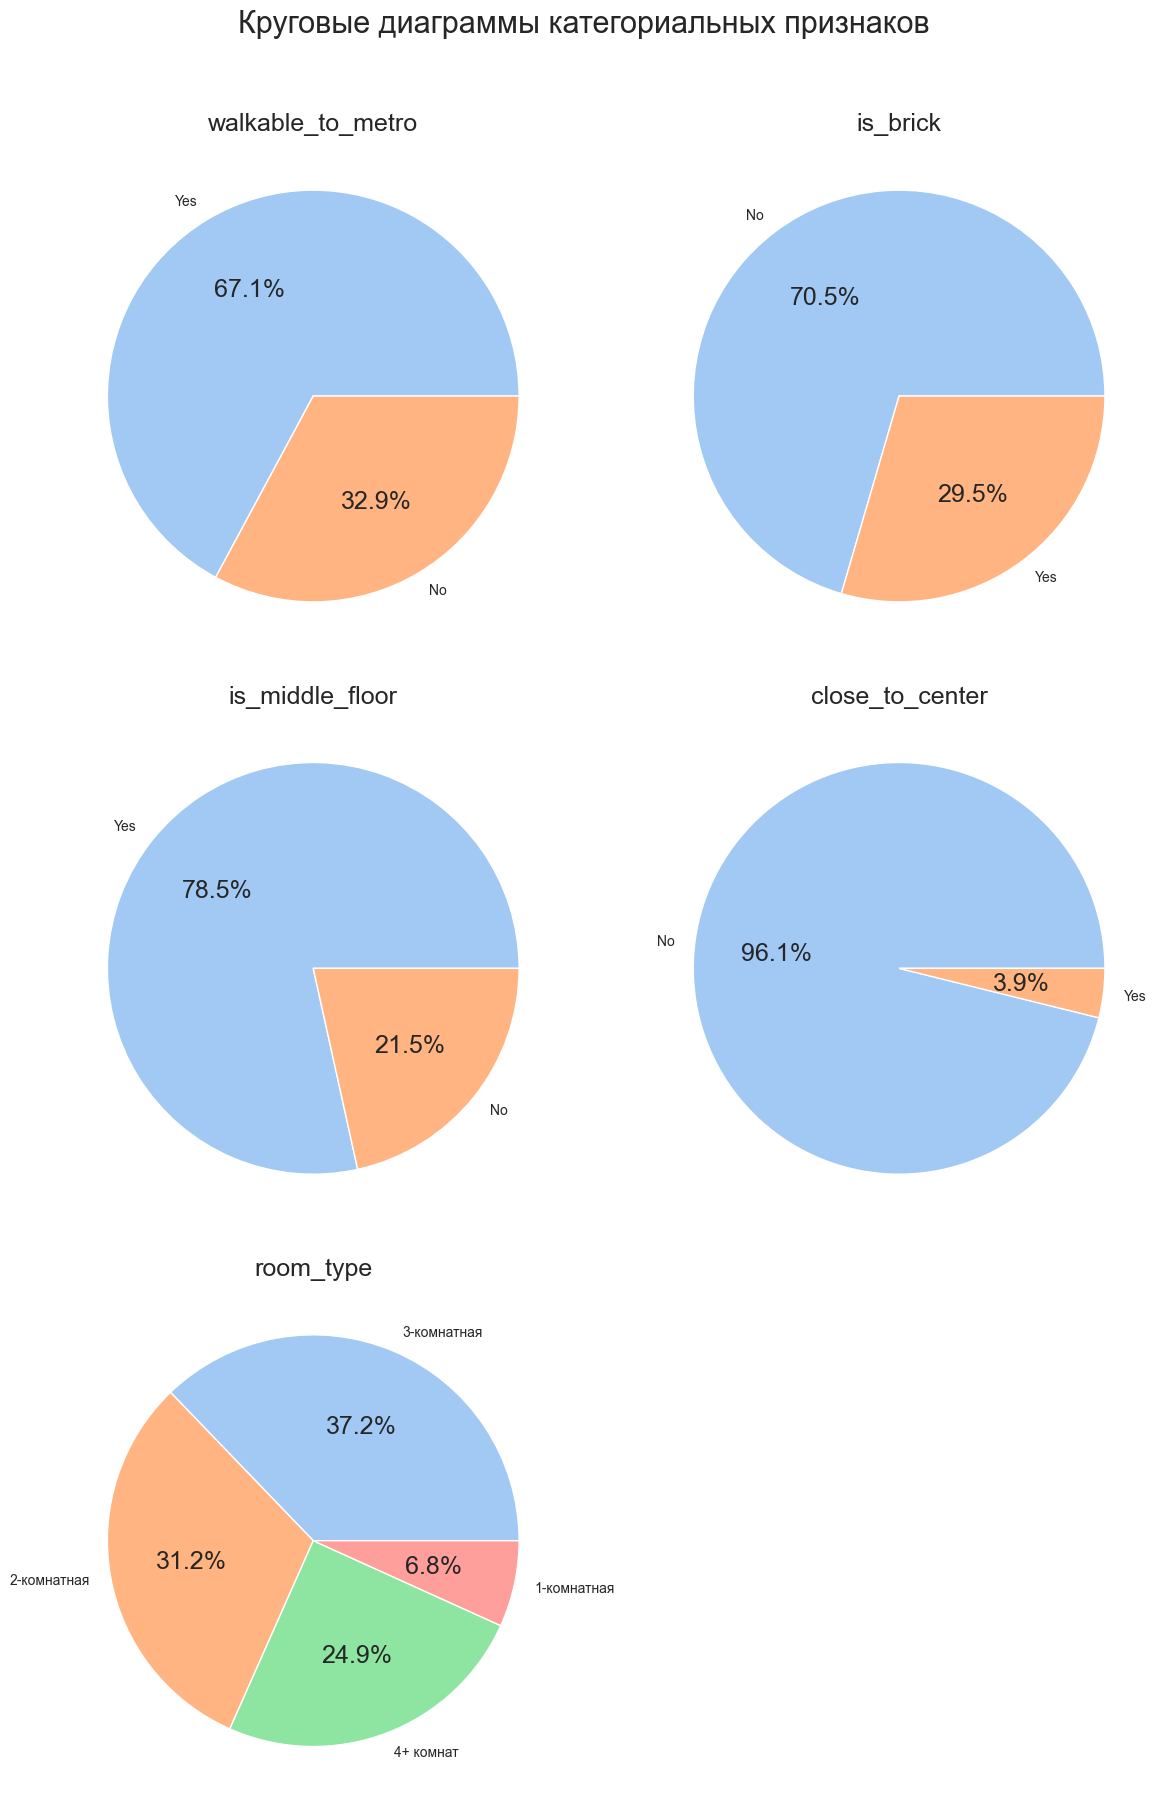

In [77]:
plot_categorial_pie(flats, flats.select_dtypes(include="object").columns, save_path="../images/data_cleaning/categorial_pie.png")

## 📊 Итоги по категориальным данным после очистки

После очистки и предобработки данных были скорректированы значения категориальных признаков и добавлены новые вычисляемые поля.

- **walkable_to_metro** — доля квартир в пешей доступности до метро составляет **≈ 67.1%**
- **is_brick** — доля квартир в кирпичных домах — **≈ 29.5%**
- **is_middle_floor** — доля квартир, расположенных не на первом и не на последнем этажах — **≈ 78.5%**

Также были добавлены новые признаки:
- **close_to_center** — доля квартир, находящихся близко к центру города (**≈ 3.9%**)
- **room_type** — распределение квартир по количеству комнат:
  - 1-комнатные — **≈ 6.8%**
  - 2-комнатные — **≈ 31.2%**
  - 3-комнатные — **≈ 37.2%**
  - 4 и более комнат — **≈ 24.9%**

Таким образом, данные категориальных признаков приведены к чистому и интерпретируемому виду, что позволяет использовать их в дальнейшем анализе.

## 9. Сохранение очищенного датасета

Сохраняем подготовленный и очищенный датасет для дальнейшего анализа гипотез.

In [78]:
flats.to_csv("../data/processed/cleaned_flats_moscow.csv", index=False)

## 💾 Завершение

Сформированный очищенный датасет сохранён и готов к дальнейшему статистическому и визуальному анализу.